In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import soundfile as sf
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import librosa


yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

import librosa

def load_audio(audio_path, target_duration=60.0, target_sample_rate=16000):
    try:
        waveform, sr = librosa.load(audio_path, sr=None, mono=True)  # Load with original sample rate
        if sr != target_sample_rate:
            waveform = librosa.resample(waveform, orig_sr=sr, target_sr=target_sample_rate)

        # Shorten or pad to 1 minute
        target_samples = int(target_duration * target_sample_rate)
        if waveform.shape[0] > target_samples:
            waveform = waveform[:target_samples]  # Truncate
        else:
            waveform = np.pad(waveform, (0, target_samples - waveform.shape[0]))  # Pad

        return waveform.astype(np.float32)

    except Exception as e:
        print(f"Skipping {audio_path} due to error: {e}")
        return np.zeros(int(target_duration * target_sample_rate), dtype=np.float32)


def extract_yamnet_features(audio_path):
    waveform = load_audio(audio_path)
    scores, embeddings, _ = yamnet_model(waveform)
    return np.mean(embeddings, axis=0)


def create_dataset(csv_path):
    df = pd.read_csv(csv_path)
    features, labels = [], []

    for _, row in df.iterrows():
        try:
            if pd.isna(row['audio_path']) or row['audio_path'].strip().lower() == "nan.wav":
                continue
            features.append(extract_yamnet_features(row['audio_path']))
            labels.append(row['composer'])
            print(f"{row['audio_path']} loaded successfully with sample rate {sr}")

        except Exception as e:
            print(f"Error processing {row['audio_path']}: {e}")

    return np.array(features), np.array(labels)





In [ ]:
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub


yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

def extract_audio_segments(audio_path, target_duration=60.0, target_sample_rate=16000, max_pad=10):
    try:
        waveform, sr = librosa.load(audio_path, sr=None, mono=True)

        if sr != target_sample_rate:
            waveform = librosa.resample(waveform, orig_sr=sr, target_sr=target_sample_rate)

        samples_per_sec = target_sample_rate
        samples_per_min = int(target_duration * samples_per_sec)

        total_minutes = int(len(waveform) / (60 * samples_per_sec))
        remaining_samples = len(waveform) % (60 * samples_per_sec)

        if total_minutes < 1:
            print(f"Skipping {audio_path}: Too short (less than 1 min).")
            return []

        start_times = list(range(1, total_minutes))

        extracted_samples = []

        for start_min in start_times:
            start_sample = int(start_min * 60 * samples_per_sec)
            end_sample = start_sample + samples_per_min


            if end_sample <= len(waveform):
                extracted_samples.append(waveform[start_sample:end_sample])
            else:
                missing_samples = end_sample - len(waveform)
                if missing_samples <= max_pad * samples_per_sec:
                    padded_waveform = np.pad(waveform[start_sample:], (0, missing_samples), mode='constant')
                    extracted_samples.append(padded_waveform)

        return extracted_samples

    except Exception as e:
        print(f"Skipping {audio_path} due to error: {e}")
        return []

def extract_yamnet_features(audio_path):
    segments = extract_audio_segments(audio_path)
    features = []

    for segment in segments:
        scores, embeddings, _ = yamnet_model(segment)
        features.append(np.mean(embeddings, axis=0))
    return features

def create_dataset(csv_path):
    df = pd.read_csv(csv_path)
    features, labels = [], []

    for _, row in df.iterrows():
        try:
            if pd.isna(row['audio_path']) or row['audio_path'].strip().lower() == "nan.wav":
                continue
            for audio_feature in extract_yamnet_features(row['audio_path']):
                features.append(audio_feature)
                labels.append(row['composer'])
            print(f"{row['audio_path']} loaded successfully with sample rate")

        except Exception as e:
            print(f"Error processing {row['audio_path']}: {e}")

    return np.array(features), np.array(labels)


updated_csv_path = "/content/drive/MyDrive/cs229Project/229Dataset/musicnet/meta_audiopath.csv"
csv_path = updated_csv_path
X, y = create_dataset(csv_path)

# Encode labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)

print("X shape:", X.shape)
print("y shape:", y.shape)
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1727.wav loaded successfully with sample rate
/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1728.wav loaded successfully with sample rate
/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1729.wav loaded successfully with sample rate
/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1730.wav loaded successfully with sample rate
/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1733.wav loaded successfully with sample rate
/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1734.wav loaded successfully with sample rate
/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1735.wav loaded successfully with sample rate
/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1739.wav loaded successfully with sample rate
/content/drive/MyDrive/c

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
X = np.load("X_features (2).npy")
y = np.load("y_labels (2).npy")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
# from tensorflow import keras
# from tensorflow.keras import layers, models

# # resnet style
# def build_classifier(num_classes):
#     inputs = layers.Input(shape=(1024,))

#     # First Residual Block
#     x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)
#     res1 = layers.Dense(512)(inputs)
#     x = layers.Add()([x, res1])
#     x = layers.Activation('relu')(x)

#     # Second Residual Block
#     x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.2)(x)
#     res2 = layers.Dense(256)(x)
#     x = layers.Add()([x, res2])
#     x = layers.Activation('relu')(x)

#     # Final Layers
#     # x = layers.Dense(128, activation='relu')(x)
#     # x = layers.LayerNormalization()(x)
#     # outputs = layers.Dense(num_classes, activation='softmax')(x)
#     x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
#     outputs = layers.Dense(num_classes, activation='softmax')(x)

#     model = models.Model(inputs, outputs)
#     return model

# # --- Training Pipeline ---


In [ ]:
#MLP with L2
def build_classifier(num_classes):
    model = models.Sequential([
        layers.Input(shape=(1024,)),  # YAMNet embeddings are 1024-dimensional
        layers.BatchNormalization(),  # BatchNorm for stable learning

        layers.Dense(512, activation='relu',
                     kernel_regularizer=regularizers.l2(0.01)),
        # L2 Regularization

        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),

        layers.BatchNormalization(),
        layers.Dense(256, activation='relu',
                     kernel_regularizer=regularizers.l2(0.01)),  # L2 Regularization
        layers.Dropout(0.3),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model

#MLP
# def build_classifier(num_classes):
#     model = models.Sequential([
#         layers.Input(shape=(1024,)),  # YAMNet embeddings are 1024-dimensional
#         layers.Dense(512, activation='relu'),
#         layers.Dropout(0.3),
#         layers.Dense(256, activation='relu'),
#         layers.Dropout(0.3),
#         layers.Dense(num_classes, activation='softmax')
#     ])
#     return model

In [ ]:
# Build model
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
num_classes = len(np.unique(y))
model = build_classifier(num_classes)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert to dictionary format expected by Keras
class_weights = {i: weight for i, weight in enumerate(class_weights)}

initial_lr = 0.01
lr_schedule = ExponentialDecay(0.0005, decay_steps=1000, decay_rate=0.96, staircase=True)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Train the model with class weighting
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=100,
          batch_size=64,
          class_weight=class_weights
          )


model.save("composer_classifier.h5")



Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.1812 - loss: 12.3780 - val_accuracy: 0.0744 - val_loss: 11.5170
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4254 - loss: 10.4663 - val_accuracy: 0.4272 - val_loss: 10.7679
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5343 - loss: 9.4805 - val_accuracy: 0.5275 - val_loss: 10.0320
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6244 - loss: 8.6298 - val_accuracy: 0.5955 - val_loss: 9.3481
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6015 - loss: 8.0301 - val_accuracy: 0.5858 - val_loss: 8.7845
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6582 - loss: 7.5606 - val_accuracy: 0.5599 - val_loss: 8.2776
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6297 - loss: 7.0582 - val_accuracy: 0.6602 - val_loss: 7.7354
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6969 - loss: 6.6295 - val_accuracy: 0.5

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


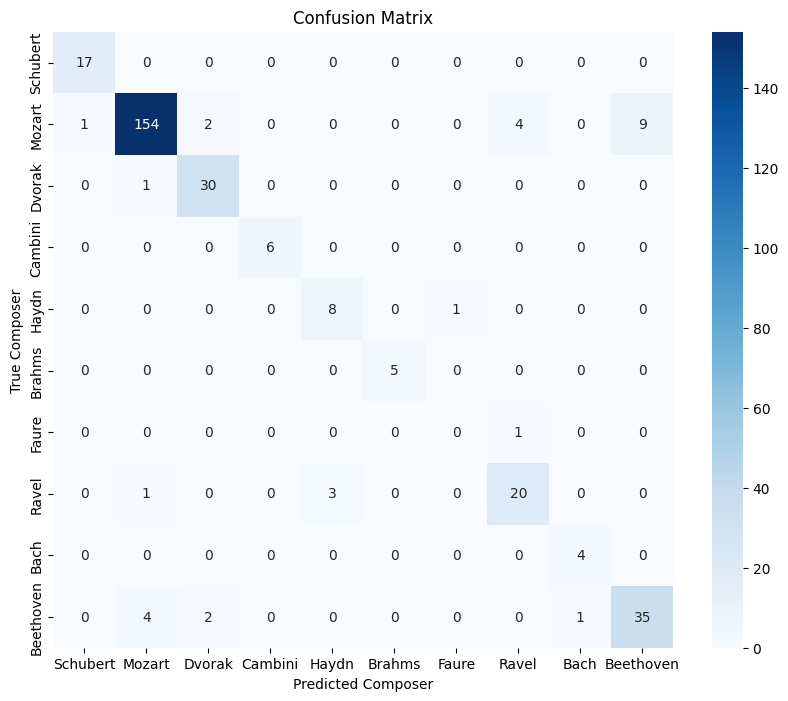

Classification Report:
              precision    recall  f1-score   support

    Schubert       0.94      1.00      0.97        17
      Mozart       0.96      0.91      0.93       170
      Dvorak       0.88      0.97      0.92        31
     Cambini       1.00      1.00      1.00         6
       Haydn       0.73      0.89      0.80         9
      Brahms       1.00      1.00      1.00         5
       Faure       0.00      0.00      0.00         1
       Ravel       0.80      0.83      0.82        24
        Bach       0.80      1.00      0.89         4
   Beethoven       0.80      0.83      0.81        42

    accuracy                           0.90       309
   macro avg       0.79      0.84      0.81       309
weighted avg       0.91      0.90      0.90       309

Accuracy: 0.9029
Precision: 0.9074
Recall: 0.9029
F1-score: 0.9040


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf

# Define composer mapping
composer_map = {
    "Schubert": 9, "Mozart": 7, "Dvorak": 4,
    "Cambini": 3, "Haydn": 6, "Brahms": 2,
    "Faure": 5, "Ravel": 8, "Bach": 0, "Beethoven": 1
}
reverse_map = {v: k for k, v in composer_map.items()}

# Make predictions
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert numeric labels to composer names
y_val_composers = [reverse_map[label] for label in y_val]
y_pred_composers = [reverse_map[label] for label in y_pred]

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=reverse_map.values(), yticklabels=reverse_map.values())
plt.xlabel('Predicted Composer')
plt.ylabel('True Composer')
plt.title('Confusion Matrix')
plt.show()

# Compute evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

# Print classification report
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=list(reverse_map.values())))

# Print summary of evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os

csv_path = "/content/drive/MyDrive/cs229Project/229Dataset/musicnet_metadata.csv"
data_df = pd.read_csv(csv_path, delimiter=";", on_bad_lines="skip")

audio_folder = "/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data"


file_map = {file.split('.')[0]: os.path.join(audio_folder, file)
             for file in os.listdir(audio_folder) if file.endswith('.wav')}

data_df['audio_path'] = data_df['id'].astype(str).map(file_map)

# Save the updated CSV
updated_csv_path = "/content/drive/MyDrive/cs229Project/229Dataset/musicnet/meta_audiopath.csv"
data_df.to_csv(updated_csv_path, index=False)

print(f"Updated CSV saved to: {updated_csv_path}")


Updated CSV saved to: /content/drive/MyDrive/cs229Project/229Dataset/musicnet/meta_audiopath.csv


In [ ]:
import os
import glob

# Check if paths match the expected structure
audio_dir = "/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/"
file_list = glob.glob(os.path.join(audio_dir, "*.wav"))

print(f"Found {len(file_list)} audio files in the correct folder.")
print("\nSample paths:")
print("\n".join(file_list[:5]))


Found 320 audio files in the correct folder.

Sample paths:
/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1727.wav
/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1728.wav
/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1729.wav
/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1730.wav
/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1733.wav


In [ ]:
import soundfile as sf

# Test reading a few files that previously failed
problematic_files = [
    "/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1730.wav",
    "/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1733.wav"
]

for path in problematic_files:
    try:
        waveform, sr = sf.read(path)
        print(extract_yamnet_features(path))

        print(f"{path} loaded successfully with sample rate {sr}")
    except Exception as e:
        print(f"Error loading {path}: {e}")



[0.01435591 0.55745673 0.02161561 ... 0.00324669 0.02120308 0.        ]
/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1730.wav loaded successfully with sample rate 44100
[0.07009655 0.34263602 0.04510509 ... 0.00960034 0.2183374  0.11416213]
/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1733.wav loaded successfully with sample rate 44100


In [ ]:
updated_csv_path = "/content/drive/MyDrive/cs229Project/229Dataset/musicnet/meta_audiopath.csv"
csv_path = updated_csv_path
X, y = create_dataset(csv_path)

# Encode labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)

print("X shape:", X.shape)
print("y shape:", y.shape)
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1727.wav loaded successfully with sample rate 44100


<ipython-input-2-cbdde1990cec>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sr = librosa.load(audio_path, sr=None, mono=True)  # Load with original sample rate
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Skipping /content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1728.wav due to error: [Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1728.wav'
/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1728.wav loaded successfully with sample rate 44100
Skipping /content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1729.wav due to error: [Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1729.wav'
/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1729.wav loaded successfully with sample rate 44100
Skipping /content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1730.wav due to error: [Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/cs229Project/229Dataset/musicnet/musicnet/train_data/1730.wav'
/content/dri

In [ ]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X shape: (320, 1024)
y shape: (320,)
X_train shape: (256, 1024)
y_train shape: (256,)
X_val shape: (64, 1024)
y_val shape: (64,)


In [ ]:
# Save features (X) and labels (y)
np.save("X_features.npy", X)
np.save("y_labels.npy", y)
print("Saved features and labels successfully.")


Saved features and labels successfully.
